# OSDG-CD Example: Scikit-learn Classifier

_This notebook provides an example of training an SDG text classifier using `scikit-learn` and OSDG Community Dataset._
***

## Table of Contents

- [I. Data Preparation](#I.-Data-Preparation)
- [II. Simple Binary SDG Classifier](#II.-Simple-Binary-SDG-Classifier)
- [III. Multi-class SDG Classifier](#III.-Multi-class-SDG-Classifier)

![17 SDGs](https://global.unitednations.entermediadb.net/assets/mediadb/services/module/asset/downloads/preset/assets/2015/09/22525/image1170x530cropped.jpg)

### Libraries

In [1]:
# standard library
from typing import List

# data wrangling
import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# nlp
import spacy

# data modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, top_k_accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# utils
from tqdm import tqdm

# local packages
from helpers import plot_confusion_matrix, get_top_features

print('Loaded!')

Loaded!


In [2]:
# other settings
%matplotlib inline
sns.set(
    style = 'whitegrid',
    palette = 'tab10',
    font_scale = 1.5,
    rc = {
        'figure.figsize': (12, 5),
        'axes.labelsize': 16
    }
)

spacy.require_gpu()
nlp = spacy.load('en_core_web_sm', disable = ['ner'])
print('Disabled spaCy components:', nlp.disabled)
print('SpaCy version:', spacy.__version__)

Disabled spaCy components: ['senter', 'ner']
SpaCy version: 3.0.6


## I. Data Preparation

_In this section, we will explore the data and select texts for training._

In [3]:
# pusing re-release data that will soon become public
df_osdg = pd.read_csv('../dataout/osdg-community-data-prerelease-v21-09-03.csv')
print('Shape:', df_osdg.shape)
display(df_osdg.head())

Shape: (31283, 7)


,text_id,doi,text,sdg,labels_positive,labels_negative,agreement
0,004c6621671e366a17fcdf481a1eff48,10.18356/5022b3a0-en,Although the impacts of these imbalances are n...,1,3,1,0.500000
1,004d6337ba90d278081c4b3d6f00a85f,10.18356/5d345c92-en,Those in the informal sector are often hit har...,1,3,0,1.000000
2,0055ba4cc458246f21d008e0363c2821,10.18356/cc778895-en,This points to the possibility that the effect...,1,6,1,0.714286
3,0065aaa240be58d5a1502859fac85680,10.18356/55fea2f6-en,"In other words, factors that might make a chil...",1,3,0,1.000000
4,0068e1e0c3989ac9674b955f559b5bdc,10.1787/9789264235120-7-en,"In Australia, where a broad definition of temp...",1,3,4,0.142857


The agreement is calculated using the following formula:

$$
agreement = \frac{|labels_{pos} - labels_{neg}|}{labels_{pos} + labels_{neg}}
$$

The resulting values range between 0 (equally split votes) and 1 (all votes are either positive or negative).

In [4]:
# calculating cumulative probability over agreement scores
df_lambda = df_osdg['agreement'].value_counts(normalize = True).sort_index().cumsum().to_frame(name = 'p_sum')
df_lambda.reset_index(inplace = True)
df_lambda.rename({'index': 'agreement'}, axis = 1, inplace = True)

print('Shape:', df_lambda.shape)
display(df_lambda.head())

Shape: (15, 2)


,agreement,p_sum
0,0.000000,0.034108
1,0.111111,0.034172
2,0.142857,0.081066
3,0.200000,0.100502
4,0.250000,0.102516


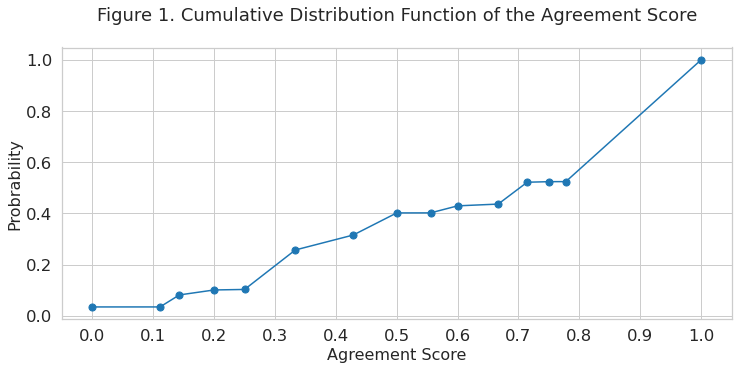

In [5]:
ax = df_lambda.plot(
    x = 'agreement',
    y = 'p_sum',
    kind = 'line',
    legend = False
)

df_lambda.plot(
    x = 'agreement',
    y = 'p_sum',
    s = 50,
    kind = 'scatter',
    color = '#1f77b4',
    ax = ax
)

ax.set(
    title = 'Figure 1. Cumulative Distribution Function of the Agreement Score\n',
    xlabel = 'Agreement Score',
    ylabel = 'Probrability',
    xticks = np.linspace(0, 1, 11)
);

In [6]:
# keeping only the texts with the minimum agreement score of .6
print('Shape before:', df_osdg.shape)
df_osdg = df_osdg.query('agreement >= .6').copy()
print('Shape after :', df_osdg.shape)
display(df_osdg.head())

Shape before: (31283, 7)
Shape after : (18713, 7)


,text_id,doi,text,sdg,labels_positive,labels_negative,agreement
1,004d6337ba90d278081c4b3d6f00a85f,10.18356/5d345c92-en,Those in the informal sector are often hit har...,1,3,0,1.000000
2,0055ba4cc458246f21d008e0363c2821,10.18356/cc778895-en,This points to the possibility that the effect...,1,6,1,0.714286
3,0065aaa240be58d5a1502859fac85680,10.18356/55fea2f6-en,"In other words, factors that might make a chil...",1,3,0,1.000000
5,008baba8edac85b8a4a4b2423b2f4f68,10.18356/39291afb-en,"According to ECLAC estimates, between 2002 and...",1,7,0,1.000000
6,00ab9cf7c4586f52a8f83f7fe05979b2,10.18356/2cb622fb-en,"Meanwhile, in some countries the predominance ...",1,3,0,1.000000


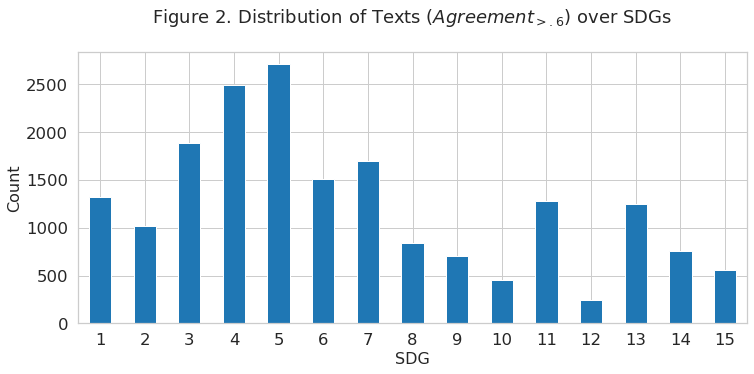

In [7]:
ax = df_osdg['sdg'].value_counts().sort_index()\
.plot(
    kind = 'bar',
    title = 'Figure 2. Distribution of Texts ($Agreement_{>.6})$ over SDGs\n',
    xlabel = 'SDG',
    ylabel = 'Count'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0);

## II. Simple Binary SDG Classifier

_Using the preselected data, we can easily train a performant binary classifier to distinguish texts relevant to a specific SDG. For a binary classification problem, we select all instances of a certain SDG and randomly undersample the remaining instances to balance things out._

**Highlights:**

- Minimum text preprocessing.
- Instances are represented as a binary vector on unigrams and bigrams.
- A binary logistic regression classifier is trained to detect texts related to SDG 5: Gender Equality.
- Test accuracy and (weighted) F1 scores each exceed `.9`.

In [8]:
sdg = 5 # selecting an sdg of interest

# undersampling the rest of sdgs to balance out the instances
mask = df_osdg['sdg'].eq(sdg).values
df_train = df_osdg.groupby(mask).sample(mask.sum(), random_state = 42)
print('Shape:', df_train.shape)
display(df_train.head())

Shape: (5416, 7)


,text_id,doi,text,sdg,labels_positive,labels_negative,agreement
29601,5097415c625cebf22fd2fbb26c012fd6,10.1787/rev/fish-2015-36-en,This is the largest individual category accoun...,14,3,0,1.000000
11136,edf4233dfd98b0832f9fa0384e8eabe7,10.1787/9789264267510-10-en,"One reason why the association is weak, even b...",4,6,1,0.714286
17831,ce06a10c01a6a97ddc8f104d02901148,10.1787/9789264100817-7-en,After adjustment for baseline sewerage coverag...,6,4,0,1.000000
644,3f30d259a7041dc367e037511454d056,10.18356/8b39d69c-en,Between the Social and the Spatial - Exploring...,1,6,1,0.714286
29570,48320f53466ca5b3ac1d9938f1e1c39e,10.6027/4a27e063-en,The taxation is currently based on 33% of the ...,14,4,0,1.000000


In [9]:
# now the classes are
df_train['target'] = df_train['sdg'].eq(sdg)
df_train['target'].value_counts()

False    2708
True     2708
Name: target, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train['text'].values,
    df_train['target'],
    test_size = .3,
    random_state = 42
)

print('Shape train:', X_train.shape)
print('Shape test:', X_test.shape)

Shape train: (3791,)
Shape test: (1625,)


In [11]:
pipe = Pipeline([
    ('vectoriser', CountVectorizer(
        ngram_range = (1, 2),
        stop_words = 'english',
        max_features = 100_000,
        binary = True
    )),
    ('clf', LogisticRegression(penalty = 'l2', C = .3, random_state = 42))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectoriser',
                 CountVectorizer(binary=True, max_features=100000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('clf', LogisticRegression(C=0.3, random_state=42))])

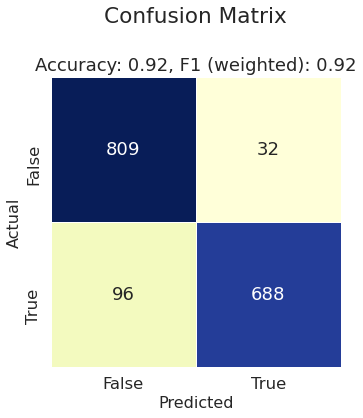

In [12]:
y_hat = pipe.predict(X_test)
plot_confusion_matrix(y_test, y_hat, (12, 6))

In [13]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

       False       0.89      0.96      0.93       841
        True       0.96      0.88      0.91       784

    accuracy                           0.92      1625
   macro avg       0.92      0.92      0.92      1625
weighted avg       0.92      0.92      0.92      1625



In [14]:
# top predictors of the positive class
get_top_features(pipe['vectoriser'], pipe['clf'], how = 'long')

,sdg,feature,coef
0,True,women,2.866803
1,True,gender,2.203320
2,True,girls,1.027671
3,True,female,0.805959
4,True,equality,0.800916
5,True,violence,0.800491
6,True,male,0.731404
7,True,family,0.647552
8,True,woman,0.603756
9,True,human,0.562790


In [15]:
# selecting a text that the model has not seen
sample = df_osdg.query('text_id not in @df_train.text_id').sample().to_dict(orient = 'records')[0]
print(
    '- SDG: {}\n- Labels positive:{}\n- Labels Negative:{}\n\n{}'\
      .format(sample['sdg'], sample['labels_positive'], sample['labels_negative'], sample['text'])
)

- SDG: 3
- Labels positive:5
- Labels Negative:0

However, there are challenges. As elsewhere, technological advances in pharmaceuticals and treatments bring both opportunities but also demands on resources while population aging is adding pressure on the system. Policymakers in Israel are also facing particularly significant difficulties in ensuring an adequate supply of health care professionals and in dealing with socio-economic divides in health outcomes.


In [16]:
pipe.predict([sample['text']])

array([False])

In [17]:
pipe.predict_proba([sample['text']])

array([[0.9375369, 0.0624631]])

## III. Multi-class SDG Classifier

_In this section, we extend the model to a multiclass case by training a multinomial logistic regression capable of classifying text input in one of 15 different SDGs._

**Highlights:**

- More sophisticated preprocessing using `spaCy`.
- Instances are represented as a real-valued vectors from a `TfIdf` matrix.
- A multinomial logistic regression classifier is trained on 15 SDGs.
- Test accuracy and (weighted) F1 scores stand at `.8`.
- Top 2 and 3 k accuracy is `.89` and `.93` accordingly.

In [18]:
def preprocess_spacy(alpha: List[str]) -> List[str]:
    """
    Preprocess text input using spaCy.
    
    Parameters
    ----------
    alpha: List[str]
        a text corpus.
    
    Returns
    -------
    doc: List[str]
        a cleaned version of the original text corpus.
    """
    docs = list()
    
    for doc in tqdm(nlp.pipe(alpha, batch_size = 128)):
        tokens = list()
        for token in doc:
            if token.pos_ in ['NOUN', 'VERB', 'ADJ']:
                tokens.append(token.lemma_)
        docs.append(' '.join(tokens))
        
    return docs

In [19]:
df_osdg['docs'] = preprocess_spacy(df_osdg['text'].values)
print('Shape:', df_osdg.shape)
display(df_osdg.head())

18713it [00:39, 474.98it/s]

Shape: (18713, 8)


,text_id,doi,text,sdg,labels_positive,labels_negative,agreement,docs
1,004d6337ba90d278081c4b3d6f00a85f,10.18356/5d345c92-en,Those in the informal sector are often hit har...,1,3,0,1.000000,informal sector hit external shock lack effect...
2,0055ba4cc458246f21d008e0363c2821,10.18356/cc778895-en,This points to the possibility that the effect...,1,6,1,0.714286,point possibility effect reduction inequality ...
3,0065aaa240be58d5a1502859fac85680,10.18356/55fea2f6-en,"In other words, factors that might make a chil...",1,3,0,1.000000,other word factor make child prone experience ...
5,008baba8edac85b8a4a4b2423b2f4f68,10.18356/39291afb-en,"According to ECLAC estimates, between 2002 and...",1,7,0,1.000000,accord estimate poverty extreme poverty fall r...
6,00ab9cf7c4586f52a8f83f7fe05979b2,10.18356/2cb622fb-en,"Meanwhile, in some countries the predominance ...",1,3,0,1.000000,country predominance growth effect period diff...


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    df_osdg['docs'].values, 
    df_osdg['sdg'].values, 
    test_size = .3,
    random_state = 42
)

print('Shape train:', X_train.shape)
print('Shape test:', X_test.shape)

Shape train: (13099,)
Shape test: (5614,)


In [21]:
pipe = Pipeline([
    ('vectoriser', TfidfVectorizer(
        ngram_range = (1, 2),
        max_df = 0.75,
        min_df = 2,
        max_features = 100_000
    )),
    ('clf', LogisticRegression(
        penalty = 'l2',
        C = .9,
        multi_class = 'multinomial',
        class_weight = 'balanced',
        random_state = 42,
        solver = 'newton-cg',
        max_iter = 100
    ))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(max_df=0.75, max_features=100000, min_df=2,
                                 ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(C=0.9, class_weight='balanced',
                                    multi_class='multinomial', random_state=42,
                                    solver='newton-cg'))])

In [22]:
print('Number of Features: {:,}'.format(len(pipe['vectoriser'].vocabulary_)))

Number of Features: 84,874


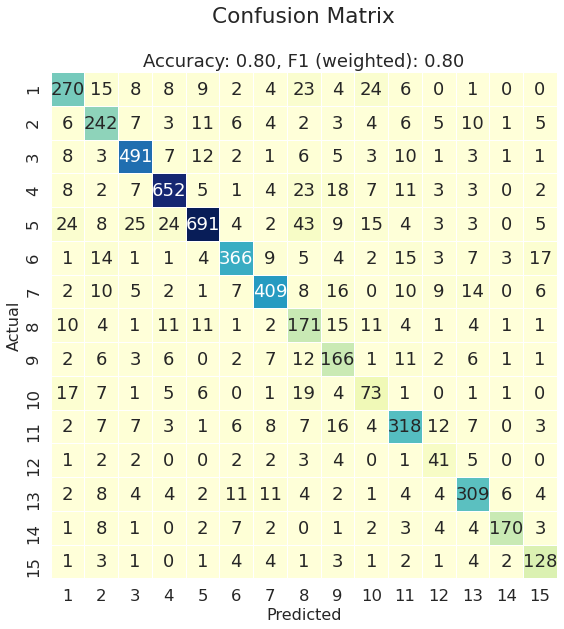

In [23]:
y_hat = pipe.predict(X_test)
plot_confusion_matrix(y_test, y_hat)

In [24]:
print(classification_report(y_test, y_hat, zero_division = 0))

              precision    recall  f1-score   support

           1       0.76      0.72      0.74       374
           2       0.71      0.77      0.74       315
           3       0.87      0.89      0.88       554
           4       0.90      0.87      0.89       746
           5       0.91      0.80      0.86       860
           6       0.87      0.81      0.84       452
           7       0.87      0.82      0.84       499
           8       0.52      0.69      0.59       248
           9       0.61      0.73      0.67       226
          10       0.49      0.54      0.51       136
          11       0.78      0.79      0.79       401
          12       0.46      0.65      0.54        63
          13       0.81      0.82      0.82       376
          14       0.91      0.82      0.86       208
          15       0.73      0.82      0.77       156

    accuracy                           0.80      5614
   macro avg       0.75      0.77      0.76      5614
weighted avg       0.81   

In [25]:
for k in [2, 3]:
    k_acc = top_k_accuracy_score(y_test, pipe.predict_proba(X_test), k = k, normalize = True)
    print(f'Top {k} accuracy: {k_acc:.2f}')

Top 2 accuracy: 0.89
Top 3 accuracy: 0.93


In [26]:
df_lambda = get_top_features(pipe['vectoriser'], pipe['clf'], top_n = 15)
print('Shape:', df_lambda.shape)
display(df_lambda.head())

Shape: (225, 3)


,sdg,feature,coef
0,1,poverty,10.893038
1,1,poor,6.590588
2,1,child,4.913196
3,1,deprivation,3.986658
4,1,income,3.865553


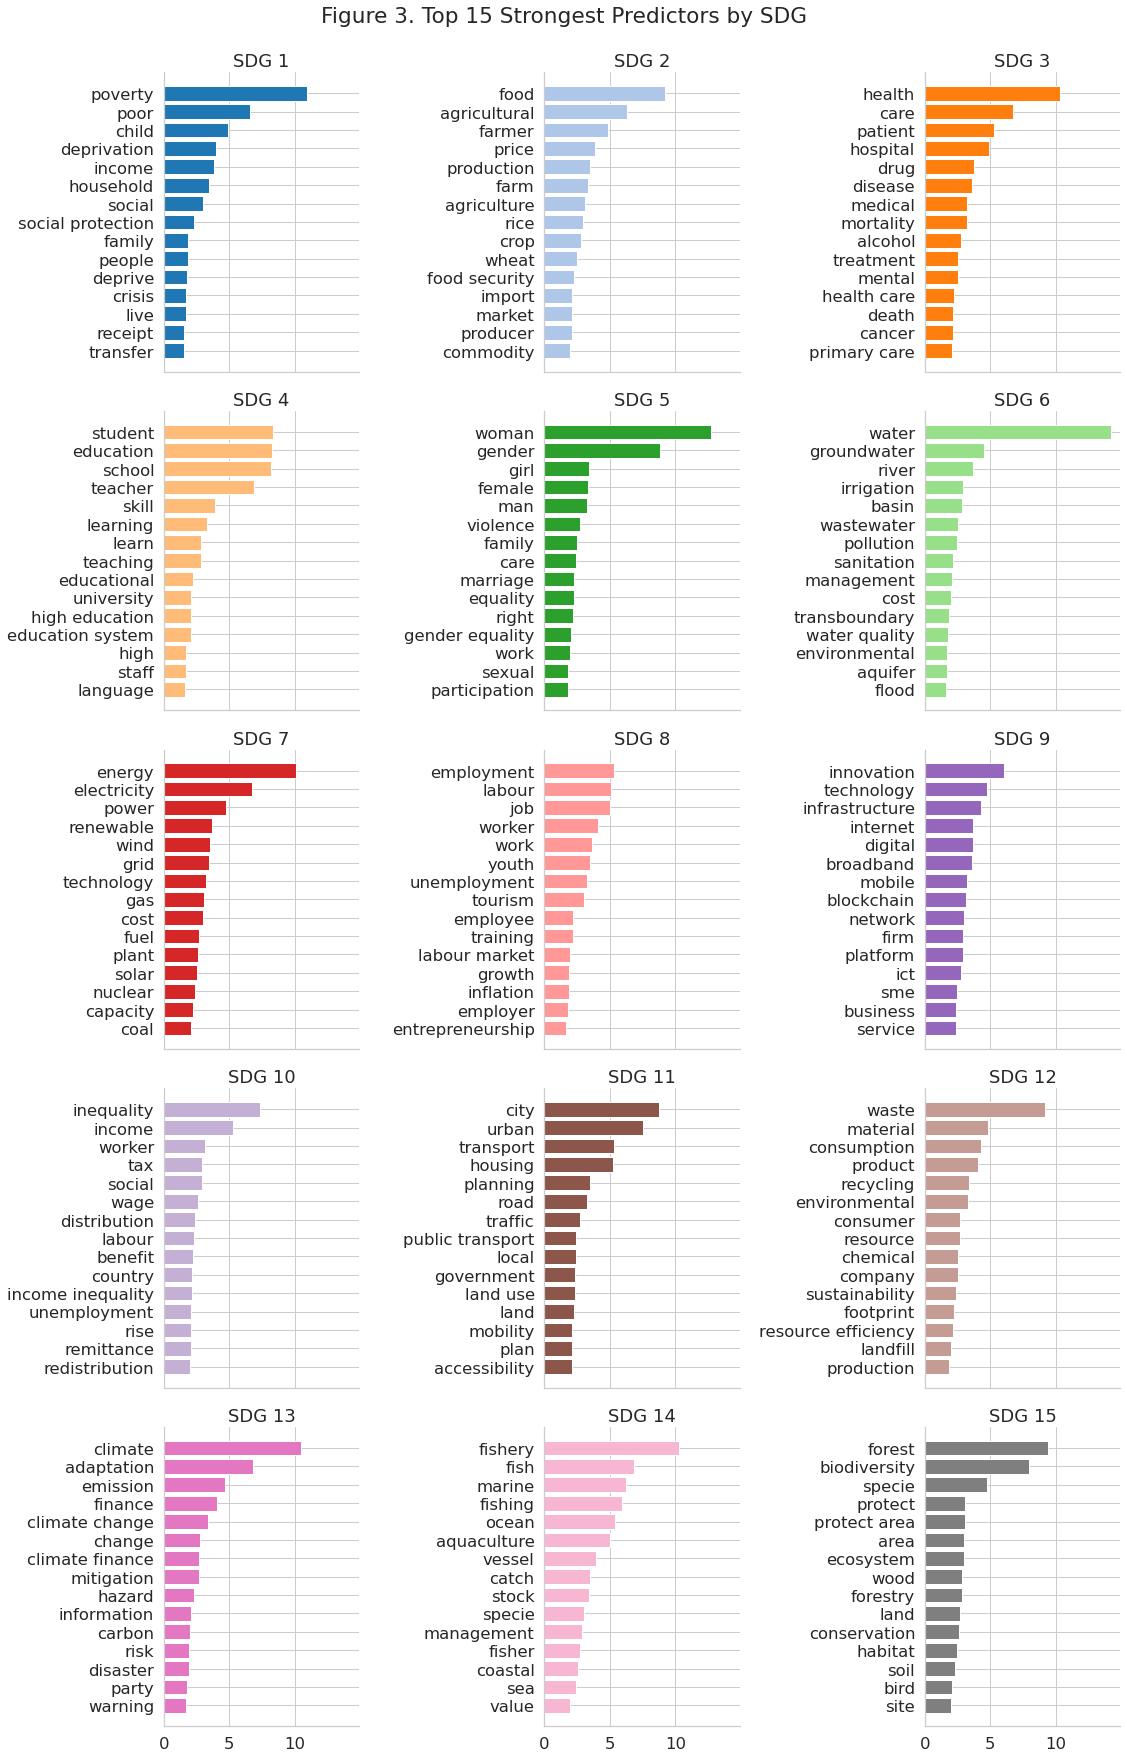

In [27]:
df_lambda.sort_values(['sdg', 'coef'], ignore_index = True, inplace = True)

f, axes = plt.subplots(5, 3, sharex = True, figsize = (16, 25))

for x in range(df_lambda['sdg'].nunique()):
    
    xs = df_lambda.query('sdg == @x + 1')['feature'].values
    ys = df_lambda.query('sdg == @x + 1')['coef'].values
    
    idx = x // 3, x % 3
    axes[idx].barh(xs, ys, color = sns.color_palette('tab20')[x])
    axes[idx].set(title = f'SDG {x + 1}')
    
sns.despine()
plt.suptitle('Figure 3. Top 15 Strongest Predictors by SDG\n')
plt.tight_layout()

In [28]:
sample = df_osdg.query('text_id not in @df_train.text_id').sample().to_dict(orient = 'records')[0]
print(
    '- SDG: {}\n- Labels positive:{}\n- Labels Negative:{}\n\n{}'\
      .format(sample['sdg'], sample['labels_positive'], sample['labels_negative'], sample['text'])
)

- SDG: 13
- Labels positive:3
- Labels Negative:0

Where formal mechanisms for national co-ordination are often not yet established, the majority of donors and supporters working in country cite a lack of national co-ordination between the Environment, Finance and Planning Ministries. In such cases, a lack of clarity exists regarding who has the role to oversee climate change funding (UNDP, 2010). Interviewees revealed a range of barriers for why this may be the case, such as the time taken between the formulation, agreement and implementation of roles, and the formulation of plans in isolation and prior to the establishment of a coordination mechanism leading to a fragmentation of domestic climate action.


In [29]:
y_proba = pipe.predict_proba([sample['text']]).flatten()
y_hat = pipe.predict([sample['text']])[0]
y_hat

13

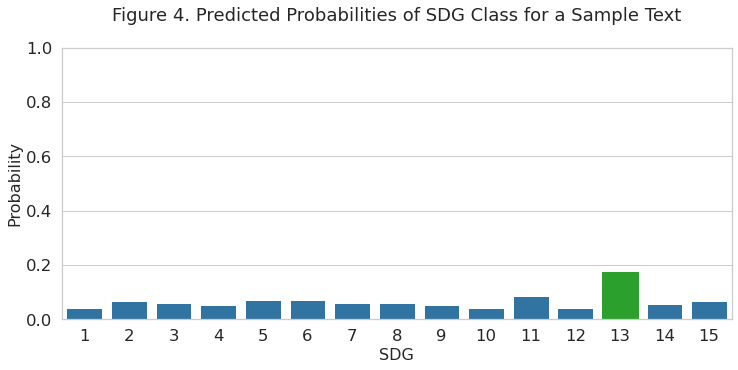

In [30]:
ax = sns.barplot(x = list(range(1, 16)), y = y_proba, color = '#1f77b4')
ax.set(
    xlabel = 'SDG',
    ylabel = 'Probability',
    ylim = (0, 1),
    title = 'Figure 4. Predicted Probabilities of SDG Class for a Sample Text\n'
)

ax.get_children()[y_proba.argmax()].set_color('#2ca02c')